In [21]:
import urllib3 
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [22]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

url = "https://ycharts.com/companies/TSLA/revenues"
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"}



html_data = requests.get(url, headers=headers, verify=False).text
time.sleep(10)

# If no information is extracted, then connect as anonymous
if "403 Forbidden" in html_data:
    headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"}
    request = requests.get(url, headers=headers, verify=False)
    time.sleep(10)
    html_data = request.text
    



In [23]:
response = requests.get(url, headers=headers, verify=False)
print(response.status_code)
html_data = response.text


200


### HTML Data saved to variable

In [24]:
print(html_data)










<!doctype html>
<html lang="en" ng-jq>
    <head>
        <title>
        Tesla Revenue (Quarterly) Analysis | YCharts
        </title>

        <meta name="viewport" content="width=device-width, initial-scale=1.0" />
<!-- This code allows us to correctly display the page on mobile devices -->
<script defer>
    var viewport = document.querySelector('meta[name=viewport]');
    if (viewport) {
        var minWidth = 700;
        if (screen.width < minWidth) {
            document.head.removeChild(viewport);
            var newViewport = document.createElement('meta');
            newViewport.setAttribute('name', 'viewport');
            newViewport.setAttribute('content', 'width=' + minWidth);
            document.head.appendChild(newViewport);
        }
    }
</script>


        
        <script>
    if (navigator.userAgent.indexOf('Trident') !== -1 || navigator.userAgent.indexOf('MSIE') !== -1) {
        window.onload=function() {
            var ie_banner = document.createEl

### Extract Headers and Rose

In [25]:

soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find('table')


headers = [] 
for th in table.find_all('th'):
    headers.append(th.text.strip())
    
soup
#print(table)

# # if table:
# #     headers = [header.text for header in table.findAll('th')]
# #     rows = table.find_all('tr')
# # else:
# #     headers = []
# #     rows = []



<!DOCTYPE html>

<html lang="en" ng-jq="">
<head>
<title>
        Tesla Revenue (Quarterly) Analysis | YCharts
        </title>
<meta content="width=device-width, initial-scale=1.0" name="viewport"/>
<!-- This code allows us to correctly display the page on mobile devices -->
<script defer="">
    var viewport = document.querySelector('meta[name=viewport]');
    if (viewport) {
        var minWidth = 700;
        if (screen.width < minWidth) {
            document.head.removeChild(viewport);
            var newViewport = document.createElement('meta');
            newViewport.setAttribute('name', 'viewport');
            newViewport.setAttribute('content', 'width=' + minWidth);
            document.head.appendChild(newViewport);
        }
    }
</script>
<script>
    if (navigator.userAgent.indexOf('Trident') !== -1 || navigator.userAgent.indexOf('MSIE') !== -1) {
        window.onload=function() {
            var ie_banner = document.createElement('div');
            ie_banner.innerT

In [26]:
tables = soup.find_all('table')
tables

[<table class="table">
 <thead>
 <tr>
 <th>Date</th>
 <th class="text-right">Value</th>
 </tr>
 </thead>
 <tbody>
 <tr>
 <td>September 30, 2024</td>
 <td class="text-right">
                             
                                 25.18B
                             
                         </td>
 </tr>
 <tr>
 <td>June 30, 2024</td>
 <td class="text-right">
                             
                                 25.50B
                             
                         </td>
 </tr>
 <tr>
 <td>March 31, 2024</td>
 <td class="text-right">
                             
                                 21.30B
                             
                         </td>
 </tr>
 <tr>
 <td>December 31, 2023</td>
 <td class="text-right">
                             
                                 25.17B
                             
                         </td>
 </tr>
 <tr>
 <td>September 30, 2023</td>
 <td class="text-right">
                             
              

In [27]:
rows = [] 
for tr in table.find_all('tr'):
    cells = tr.find('td')
    if cells:
        rows = [cells.text.strip() for cell in cells]
        rows.append(rows)


In [28]:
rows = [] 
for tr in table.find_all('tr'):
    cells = tr.find_all('td')
    if cells:
        row = [cell.text.strip() for cell in cells]
        rows.append(row)

scrape_df = pd.DataFrame(rows, columns=headers)

### Clean Dataframe

In [29]:
scrape_df.head()

,Date,Value
0,"September 30, 2024",25.18B
1,"June 30, 2024",25.50B
2,"March 31, 2024",21.30B
3,"December 31, 2023",25.17B
4,"September 30, 2023",23.35B


In [30]:
scrape_df = scrape_df.replace('$', ' ')
scrape_df =scrape_df.replace(',', '')

In [31]:
scrape_df.head()

,Date,Value
0,"September 30, 2024",25.18B
1,"June 30, 2024",25.50B
2,"March 31, 2024",21.30B
3,"December 31, 2023",25.17B
4,"September 30, 2023",23.35B


In [32]:
conn = sqlite3.connect('scrapedb.db')

In [33]:
cursor = conn.cursor()

In [34]:
stock_prices = '''
CREATE TABLE IF NOT EXISTS SCRAPE (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    Date DATETIME,
    value INT   
)
'''

In [36]:
# Iterate over the rows of the DataFrame and insert each row into the SCRAPE table
for index, row in scrape_df.iterrows():
    cursor.execute('''
        INSERT INTO stock_prices (Date, value)
        VALUES (?, ?)
    ''', (row['Date'], row['Value']))

# Commit the transaction
conn.commit()

In [38]:
stock_prices = scrape_df.to_sql('stock_prices', conn, if_exists='append')
cursor.execute('SELECT * FROM stock_prices')
for row in cursor.fetchall():
    print(row)

(0, 'September 30, 2024', '25.18B')
(1, 'June 30, 2024', '25.50B')
(2, 'March 31, 2024', '21.30B')
(3, 'December 31, 2023', '25.17B')
(4, 'September 30, 2023', '23.35B')
(5, 'June 30, 2023', '24.93B')
(6, 'March 31, 2023', '23.33B')
(7, 'December 31, 2022', '24.32B')
(8, 'September 30, 2022', '21.45B')
(9, 'June 30, 2022', '16.93B')
(10, 'March 31, 2022', '18.76B')
(11, 'December 31, 2021', '17.72B')
(12, 'September 30, 2021', '13.76B')
(13, 'June 30, 2021', '11.96B')
(14, 'March 31, 2021', '10.39B')
(15, 'December 31, 2020', '10.74B')
(16, 'September 30, 2020', '8.771B')
(17, 'June 30, 2020', '6.036B')
(18, 'March 31, 2020', '5.985B')
(19, 'December 31, 2019', '7.384B')
(20, 'September 30, 2019', '6.303B')
(21, 'June 30, 2019', '6.35B')
(22, 'March 31, 2019', '4.541B')
(23, 'December 31, 2018', '7.226B')
(24, 'September 30, 2018', '6.824B')
(0, 'September 30, 2024', '25.18B')
(1, 'June 30, 2024', '25.50B')
(2, 'March 31, 2024', '21.30B')
(3, 'December 31, 2023', '25.17B')
(4, 'Septemb

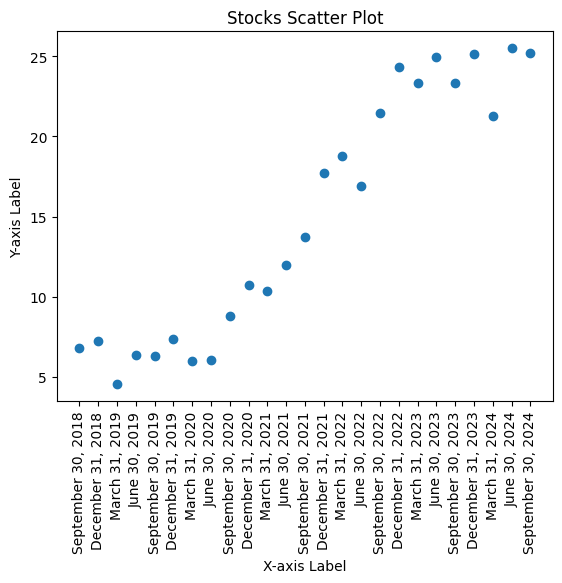

In [52]:
import matplotlib.pyplot as plt


plt.scatter(scrape_df['Date'], scrape_df['Value'])
# Step 4: Add titles and labels
plt.xticks(rotation=90)
plt.title('Stocks Scatter Plot')
plt.xlabel('X-axis Label')
plt.gca().invert_xaxis()
plt.ylabel('Y-axis Label')

# Step 5: Display the plot
plt.show()


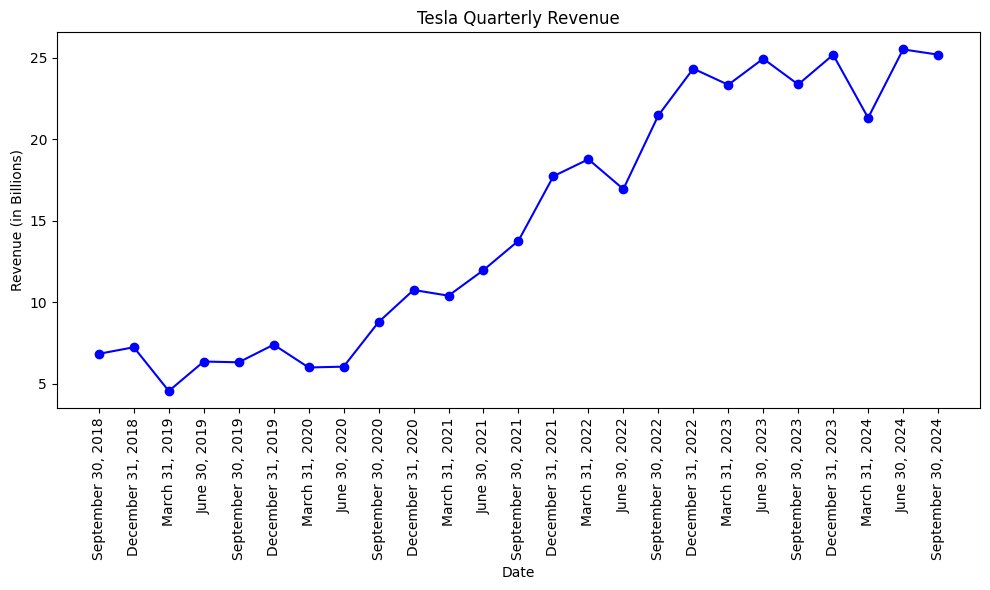

In [50]:
import matplotlib.pyplot as plt

# Convert 'Value' column to numeric by removing 'B' and converting to float
#scrape_df['Value'] = scrape_df['Value'].str.replace('B', '').astype(float)

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.plot(scrape_df['Date'], scrape_df['Value'], marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Revenue (in Billions)')
plt.title('Tesla Quarterly Revenue')
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

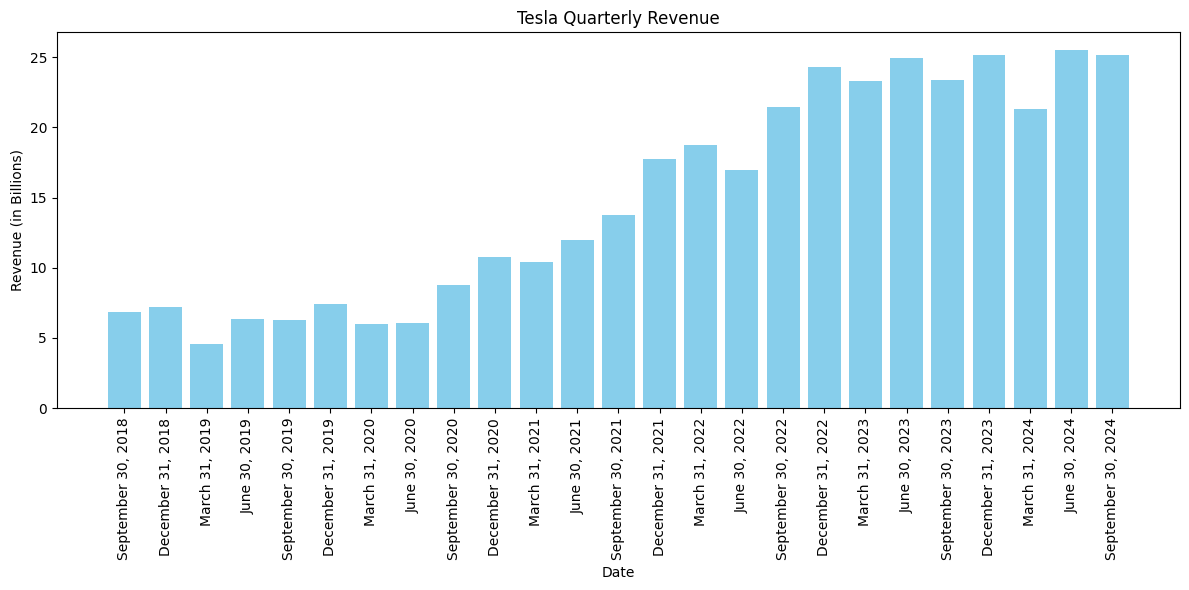

In [49]:
import matplotlib.pyplot as plt

# Create a bar chart for Tesla's quarterly revenues
plt.figure(figsize=(12, 6))
plt.bar(scrape_df['Date'], scrape_df['Value'], color='skyblue')
plt.xlabel('Date')
plt.ylabel('Revenue (in Billions)')
plt.title('Tesla Quarterly Revenue')
plt.xticks(rotation=90)
plt.tight_layout()
plt.gca().invert_xaxis()
plt.show()